In [2]:
!pip install casadi
import os
from IPython.display import clear_output

import numpy as np
import casadi
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import patches

import os
os.makedirs('images',exist_ok=True)
if os.name == 'nt':
    plt.rcParams['font.family'] = 'MS Gothic'
elif os.name == 'posix':
    !pip install japanize-matplotlib
    import japanize_matplotlib

clear_output()

from scipy.integrate import solve_ivp

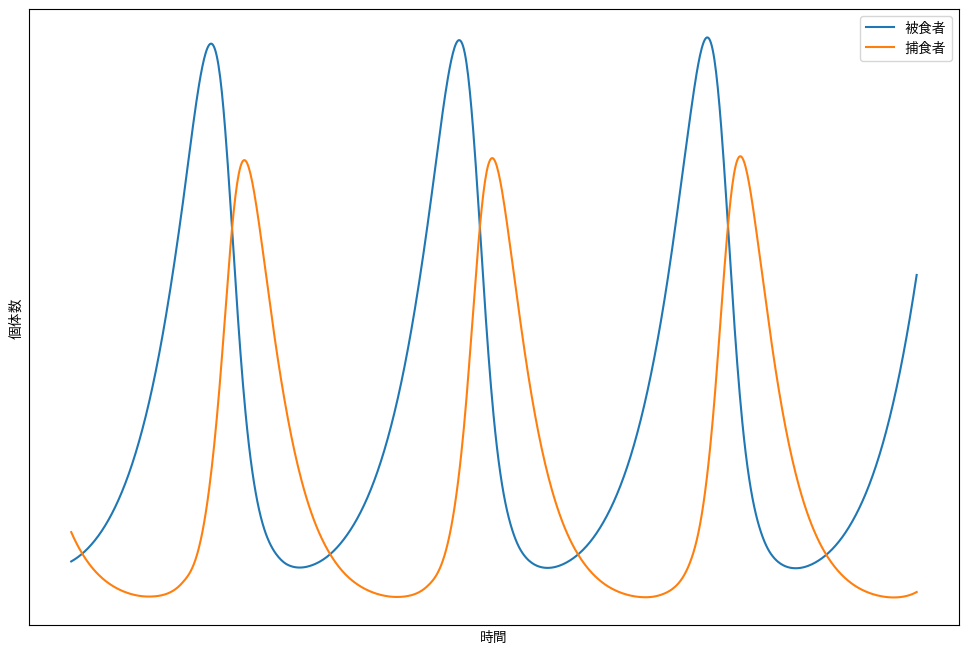

In [36]:
a = 20
b = 1
c = 1
d = 30

def f(t,x):
    u,v = x
    du_dt = a*u - b*u*v
    dv_dt = c*u*v - d*v
    dx_dt = np.stack([du_dt,dv_dt])
    return dx_dt

T_s = 0.0
T_e = 1.0
N = 1000
x0 = np.array([8,12])
t_span = np.array([T_s,T_e])
t_eval = np.linspace(*t_span,N)

res = solve_ivp(f,t_span,x0,"RK45",t_eval)
res_t = res.t
res_y = res.y

plt.figure(figsize=(12,8))
plt.plot(res_t,res_y[0],label="被食者")
plt.plot(res_t,res_y[1],label="捕食者")
plt.tick_params(labelleft=False,left=False,labelbottom=False,bottom=False)
plt.ylabel("個体数")
plt.xlabel("時間")
plt.legend()
plt.show()

In [ ]:
a = 0.06
b = 0.06
c = 0.024
d = 0.06
e = 0.06
f = 0.012

# 予測ホライズン等
K = 30

nu = 1 #制御変数の次元
nx = 2 #状態変数の次元
total = nx*(K+1) + nu*K #最適化変数の次元

# コスト関数の重み
Q = casadi.diag([1,1])
Q_f = casadi.diag([1,1])
R = casadi.diag([0.05])

# 制約条件
x_lb = [0,0]
x_ub = [np.inf,np.inf]
u_lb = [0]
u_ub = [1]

# 目標値
x_ref = casadi.DM([1,1])
u_ref = casadi.DM([0])

def make_F():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    x = states[0]
    y = states[1]
    u = ctrls[0]

    x_next = (1+a)*x -b*x*y - c*x*u
    y_next = (1-d)*y + e*x*y - f*y*u

    states_next = casadi.vertcat(x_next,y_next)

    F = casadi.Function("F",[states,ctrls],[states_next],['x','u'],['x_next'])
    return F